# **Bibliotecas**

In [1]:
%%capture

!pip install shap
!pip install optuna

In [2]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

# **Funções**

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [3]:
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Dados**

In [4]:
# Baixando todos os arquivos dos tipos de câncer
!gdown 1gCvb72254hSgR3uRDNnkuvypdKMDXE-E --quiet # Colorretal
!gdown 1-5TMUdCHgLEBig1F5a4rRuTT5MdT4Lrw --quiet # Pulmão
!gdown 1-AY70uv61sBGJbUFCiF8Igyes3eP6ymm --quiet # Mama
!gdown 1-ApWhBLZG4NdOtLiwlaYflR2EzTB5vV8 --quiet # Colo de Útero
!gdown 1-HKn3Rk1i9hRAK06khtSF9lf9bInZ3HS --quiet # Próstata
!gdown 1-PJi2-Tu6-AD9PVmVb5Pbx3IzVy8vnr3 --quiet # Pele

In [5]:
# Leitura dos dados de colo de útero
df_prostata = pd.read_csv('prostata.csv')
print(df_prostata.shape)
df_prostata.head(3)

(94106, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,24,1,3524402,2,2,C619,C61,I,C,0,...,17,3524402,1,2.0,1,1,0,1,1,1
1,22,1,3519204,2,2,C619,C61,I,J,1,...,10,3555000,1,2.0,0,0,0,1,0,0
2,20,1,3502804,2,1,C619,C61,II,B,0,...,12,3502804,1,2.0,1,1,0,1,1,1


In [6]:
# Valores faltantes
df_prostata.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [7]:
df_prostata_ano5 = df_prostata[~((df_prostata.obito_geral == 0) & (df_prostata.sobrevida_ano5 == 0))].reset_index(drop=True)
df_prostata_ano5.shape

(68490, 32)

In [8]:
# Correlação com a saída
corr_matrix = df_prostata_ano5.corr()
abs(corr_matrix['sobrevida_ano5']).sort_values(ascending=False).head(20)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


sobrevida_ano5        1.000000
sobrevida_ano3        0.763281
obito_geral           0.630403
sobrevida_ano1        0.409182
IDADE                 0.244511
CIRURGIA              0.172602
QUIMIO                0.156414
HORMONIO              0.138118
ESCOLARI_preench      0.103440
TRATCONS              0.098955
DIAGTRAT              0.096254
NENHUM                0.090021
DIAGPREV              0.082555
RADIO                 0.063037
CATEATEND             0.061458
ANODIAG               0.040690
IMUNO                 0.031534
IBGE_idem_IBGEATEN    0.029547
RRAS                  0.025100
HABILIT2              0.022089
Name: sobrevida_ano5, dtype: float64

In [9]:
# Quantidade de pacientes em cada classe da saída
df_prostata_ano5.sobrevida_ano5.value_counts()

1    48501
0    19989
Name: sobrevida_ano5, dtype: int64

## **Pré-processamento**

In [10]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'obito_geral', 'sobrevida_ano1',
             'sobrevida_ano3']

lb = 'sobrevida_ano5'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_prostata_ano5,
                                                                       list_drop, lb,
                                                                    #    ohe_encoder=['TRATHOSP'],
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (51367, 25), X_test = (17123, 25)
y_train = (51367,), y_test = (17123,)


In [11]:
y_train.value_counts(normalize=True)

1    0.708139
0    0.291861
Name: sobrevida_ano5, dtype: float64

In [12]:
y_test.value_counts(normalize=True)

1    0.70817
0    0.29183
Name: sobrevida_ano5, dtype: float64

# **Treinamento e validação dos modelos de machine learning**

## **Random Forest**


### **Modelo base**

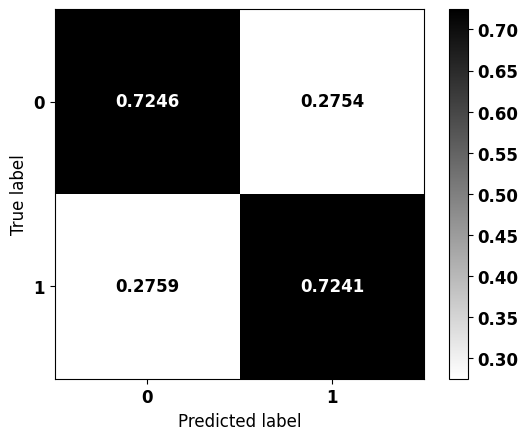


              precision    recall  f1-score   support

           0     0.5197    0.7246    0.6053      4997
           1     0.8645    0.7241    0.7881     12126

    accuracy                         0.7242     17123
   macro avg     0.6921    0.7243    0.6967     17123
weighted avg     0.7639    0.7242    0.7347     17123



In [13]:
# Criação e treinamento do modelo Random Forest
rf = RandomForestClassifier(random_state=seed,
                            class_weight={0:3.08, 1:1},
                            max_depth=10,
                            criterion='entropy')

rf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(rf, X_test, y_test)

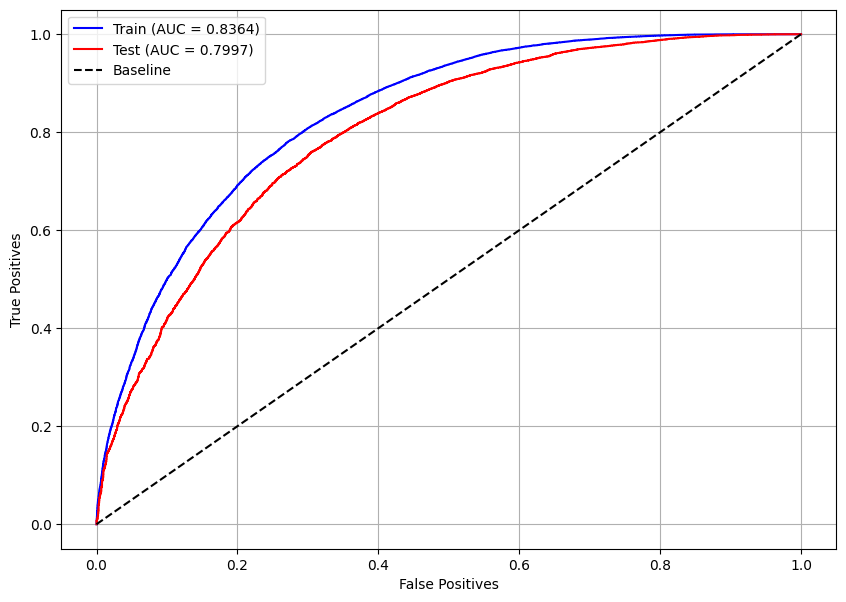

In [ ]:
# Curva ROC
plot_roc_curve(rf, X_train, X_test, y_train, y_test)

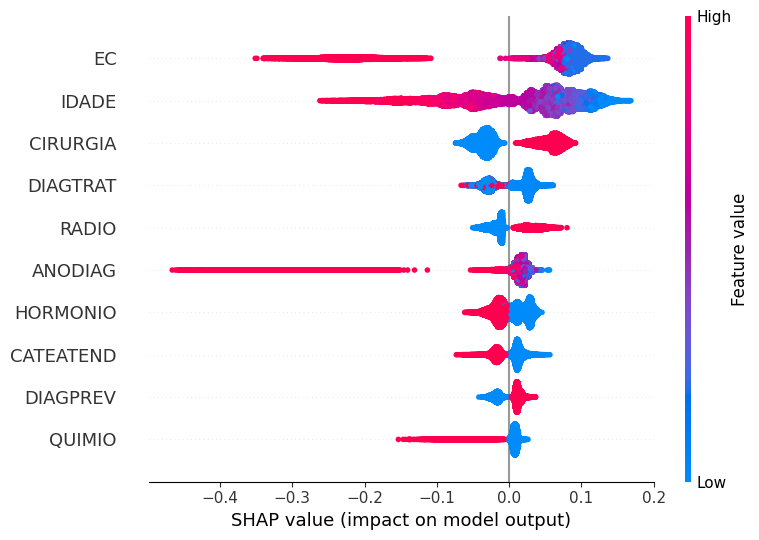

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(rf, X_train, feat_cols)

### **Optuna**

In [14]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelo e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)
    max_samples = trial.suggest_float('max_samples', 0.7, 1.0, step=0.1)
    # optimizer = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    cls = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_samples=max_samples,
                                #  criterion=optimizer,
                                 random_state=seed,
                                 n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyRF.best_trial

FrozenTrial(number=20, state=TrialState.COMPLETE, values=[0.7937780287414562], datetime_start=datetime.datetime(2023, 10, 17, 2, 12, 20, 440002), datetime_complete=datetime.datetime(2023, 10, 17, 2, 13, 28, 238901), params={'n_estimators': 125, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_samples': 0.7999999999999999, 'criterion': 'gini'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=7, log=False, low=1, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.7, step=0.1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=20, value=None)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 125,
 'max_depth': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_samples': 0.7999999999999999,
 'criterion': 'gini'}

In [ ]:
pesos = np.round(np.arange(3, 3.3, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

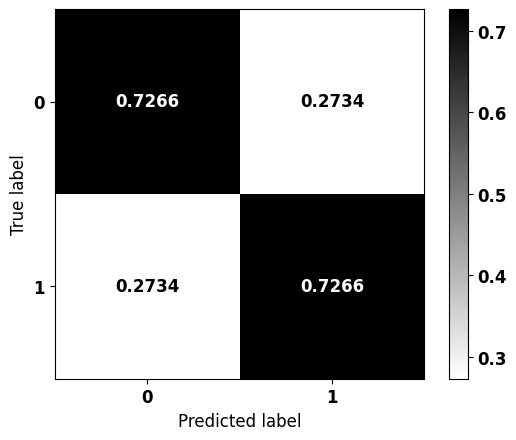


              precision    recall  f1-score   support

           0     0.5227    0.7266    0.6081      4997
           1     0.8658    0.7266    0.7901     12126

    accuracy                         0.7266     17123
   macro avg     0.6943    0.7266    0.6991     17123
weighted avg     0.7657    0.7266    0.7370     17123



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:3.112, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

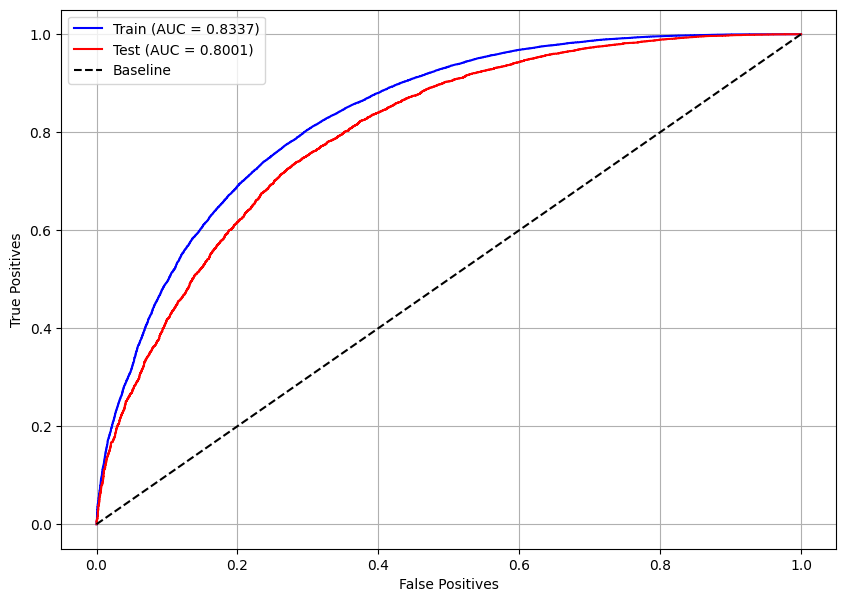

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 99,
 'max_depth': 10,
 'min_samples_split': 6,
 'min_samples_leaf': 7,
 'max_samples': 0.7999999999999999,
 'criterion': 'gini'}

In [ ]:
pesos = np.round(np.arange(3, 3.3, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

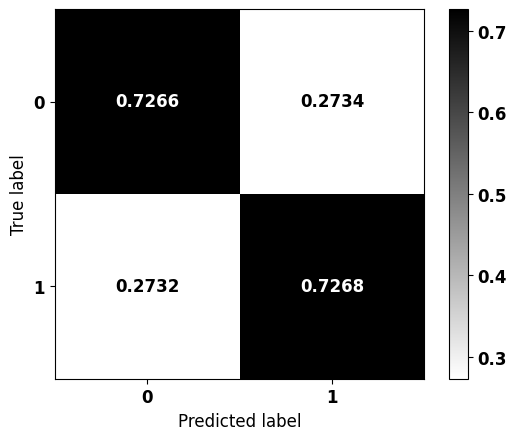


              precision    recall  f1-score   support

           0     0.5229    0.7266    0.6082      4997
           1     0.8658    0.7268    0.7902     12126

    accuracy                         0.7267     17123
   macro avg     0.6943    0.7267    0.6992     17123
weighted avg     0.7657    0.7267    0.7371     17123



In [19]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:3.081, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

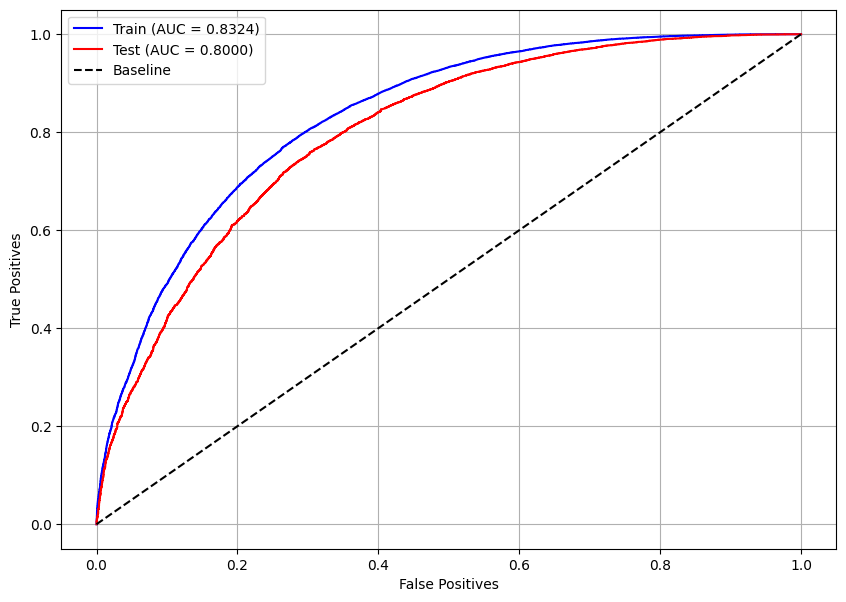

In [20]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [18]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 119,
 'max_depth': 10,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_samples': 0.7999999999999999}

In [19]:
pesos = np.round(np.arange(3, 3.3, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

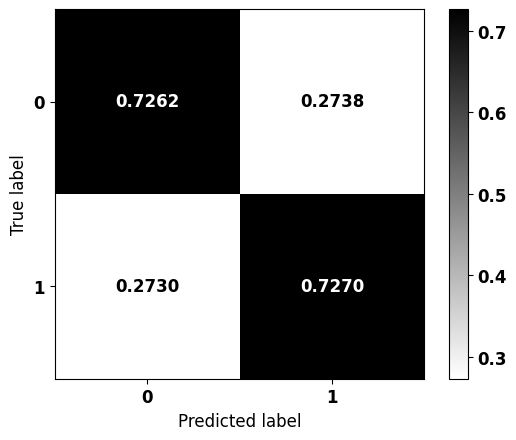


              precision    recall  f1-score   support

           0     0.5229    0.7262    0.6080      4997
           1     0.8657    0.7270    0.7903     12126

    accuracy                         0.7267     17123
   macro avg     0.6943    0.7266    0.6991     17123
weighted avg     0.7656    0.7267    0.7371     17123



In [20]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:3.119, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

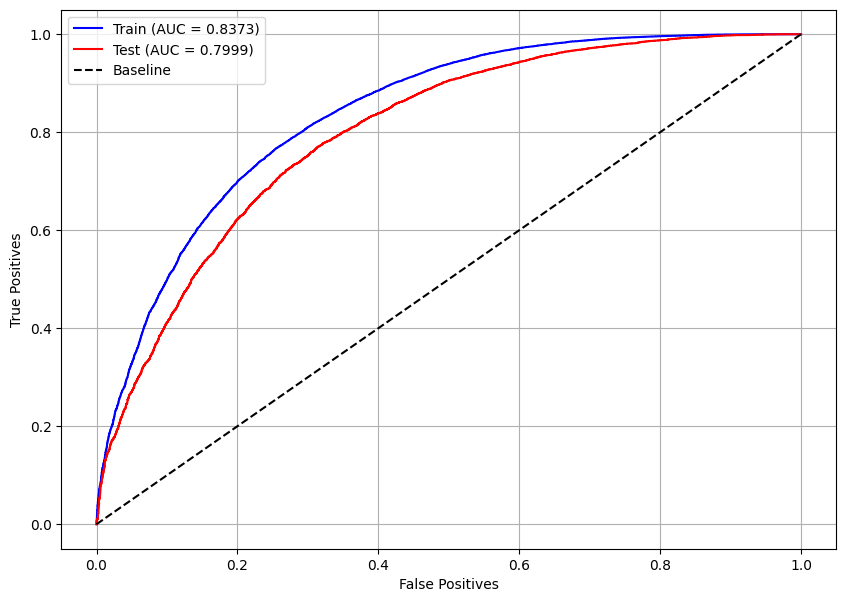

In [21]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

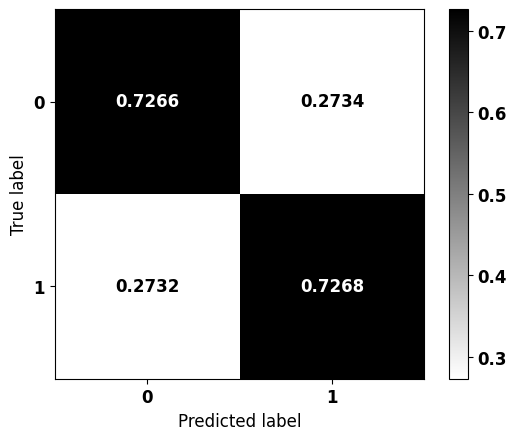


              precision    recall  f1-score   support

           0     0.5229    0.7266    0.6082      4997
           1     0.8658    0.7268    0.7902     12126

    accuracy                         0.7267     17123
   macro avg     0.6943    0.7267    0.6992     17123
weighted avg     0.7657    0.7267    0.7371     17123



In [22]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 99, 'max_depth': 10, 'min_samples_split': 6,
          'min_samples_leaf': 7, 'max_samples': 0.8, 'criterion': 'gini'}

params['random_state'] = seed
params['class_weight'] = {0:3.081, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

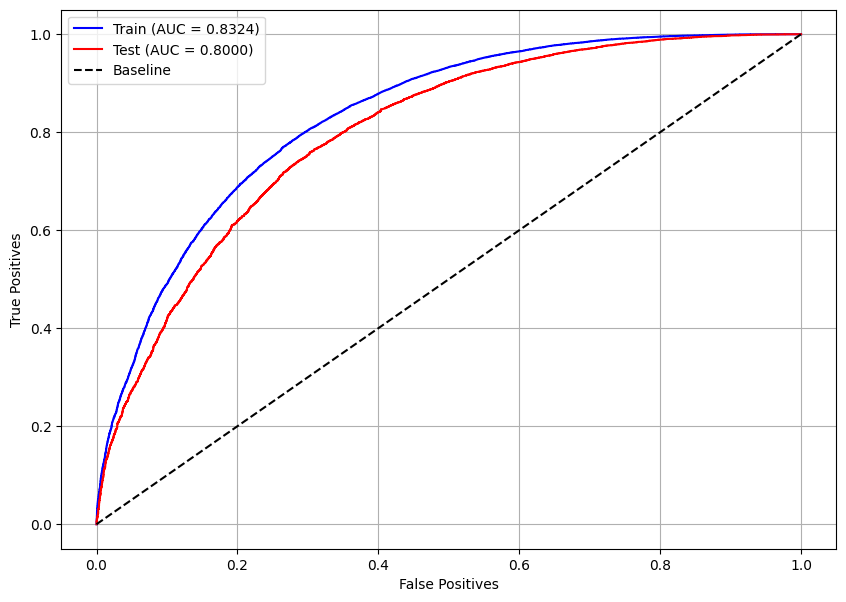

In [23]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

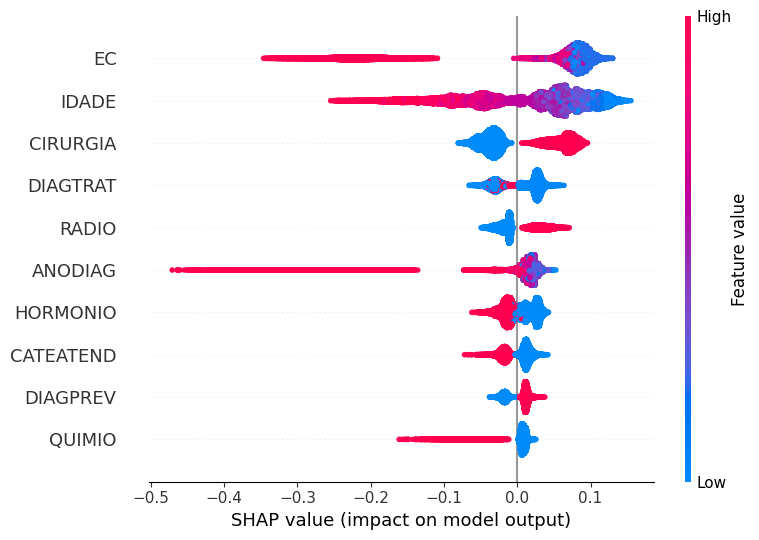

In [24]:
# Importância das features pelos valores SHAP do modelo otimizado
plot_shap_values(rf_optuna, X_train, feat_cols)

## **XGBoost**


### **Modelo base**

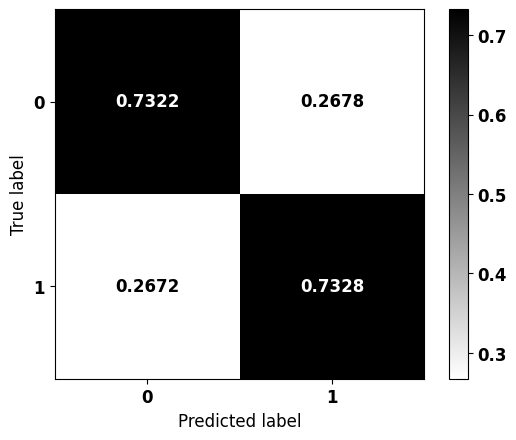


              precision    recall  f1-score   support

           0     0.5304    0.7322    0.6152      4997
           1     0.8691    0.7328    0.7952     12126

    accuracy                         0.7326     17123
   macro avg     0.6997    0.7325    0.7052     17123
weighted avg     0.7703    0.7326    0.7426     17123



In [46]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=5,
                    scale_pos_weight=0.3335,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

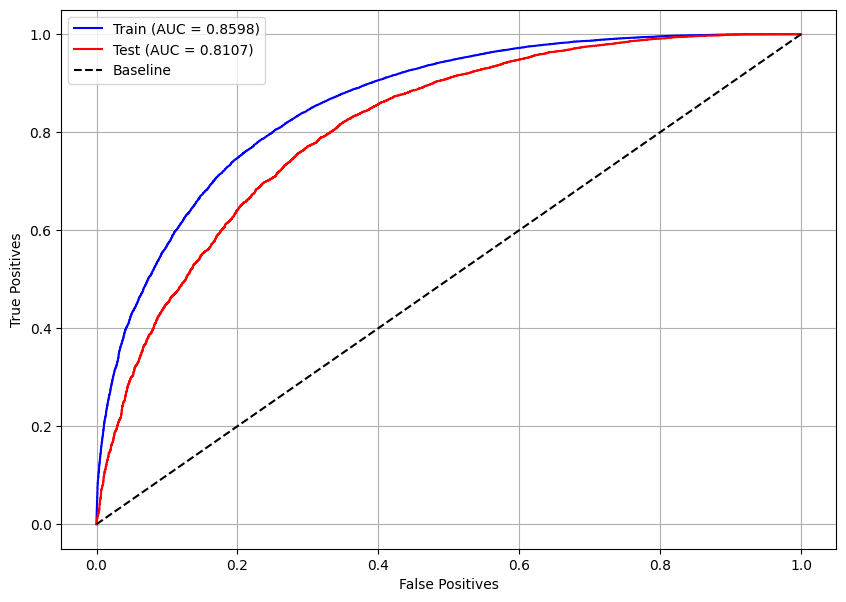

In [47]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

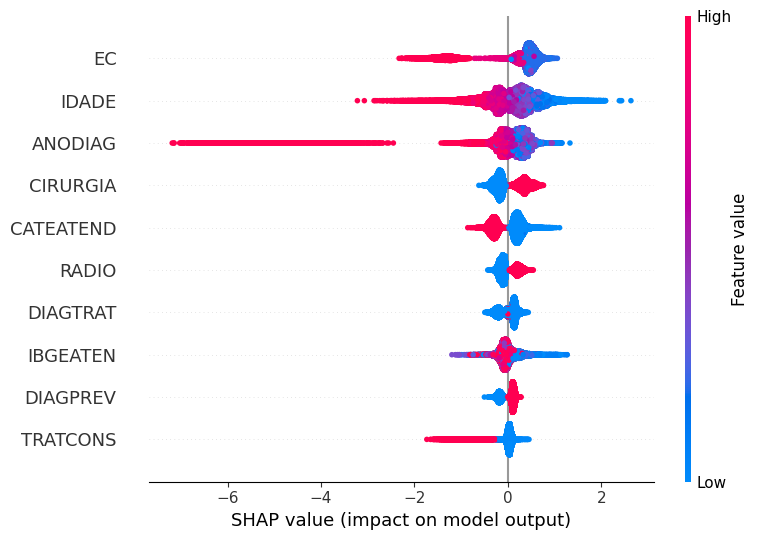

In [48]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

### **Optuna**

In [49]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelo e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [51]:
# Melhor tentativa
studyXGB.best_trial

FrozenTrial(number=73, state=TrialState.COMPLETE, values=[0.8001634990967126], datetime_start=datetime.datetime(2023, 10, 17, 14, 33, 25, 771239), datetime_complete=datetime.datetime(2023, 10, 17, 14, 33, 43, 512403), params={'n_estimators': 147, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.3, 'min_child_weight': 7, 'colsample_bytree': 0.5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=6, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.05), 'gamma': FloatDistribution(high=0.3, log=False, low=0.0, step=0.1), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=73, value=None)

In [52]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 147,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'min_child_weight': 7,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(0.32, 0.34, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

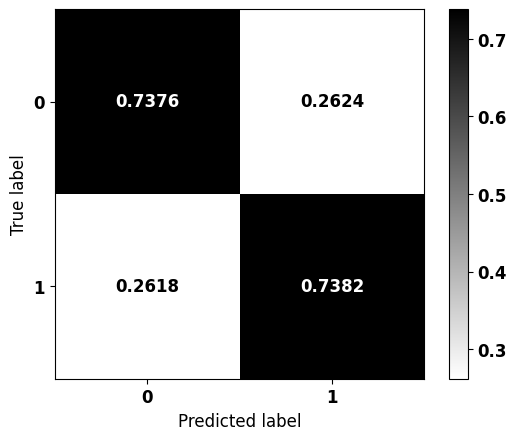


              precision    recall  f1-score   support

           0     0.5372    0.7376    0.6217      4997
           1     0.8722    0.7382    0.7996     12126

    accuracy                         0.7380     17123
   macro avg     0.7047    0.7379    0.7107     17123
weighted avg     0.7745    0.7380    0.7477     17123



In [54]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.3357

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

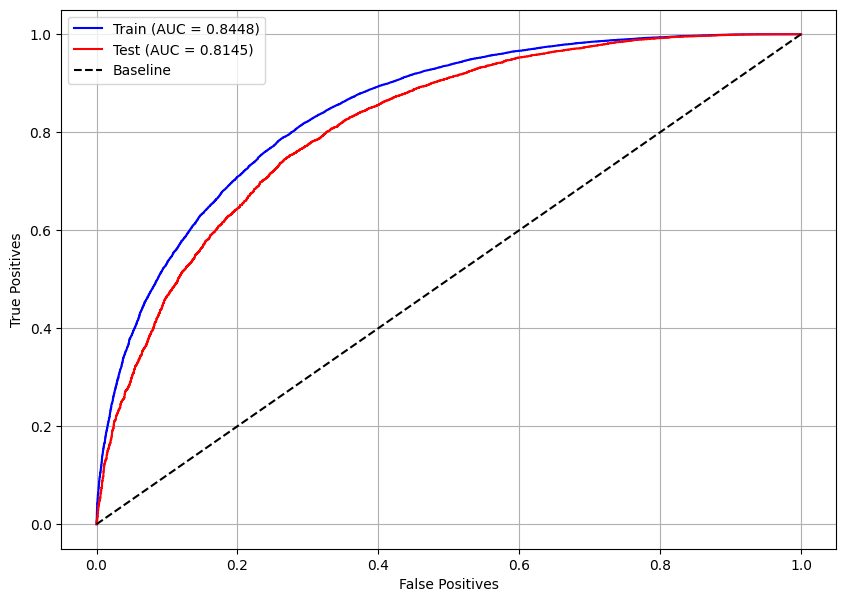

In [55]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [57]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 104,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'min_child_weight': 2,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(0.32, 0.34, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

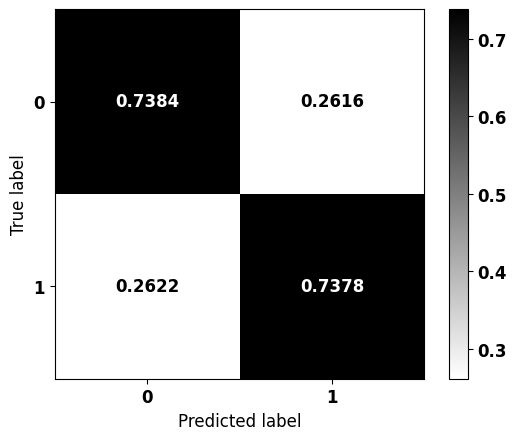


              precision    recall  f1-score   support

           0     0.5371    0.7384    0.6219      4997
           1     0.8725    0.7378    0.7995     12126

    accuracy                         0.7380     17123
   macro avg     0.7048    0.7381    0.7107     17123
weighted avg     0.7746    0.7380    0.7477     17123



In [59]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.329

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

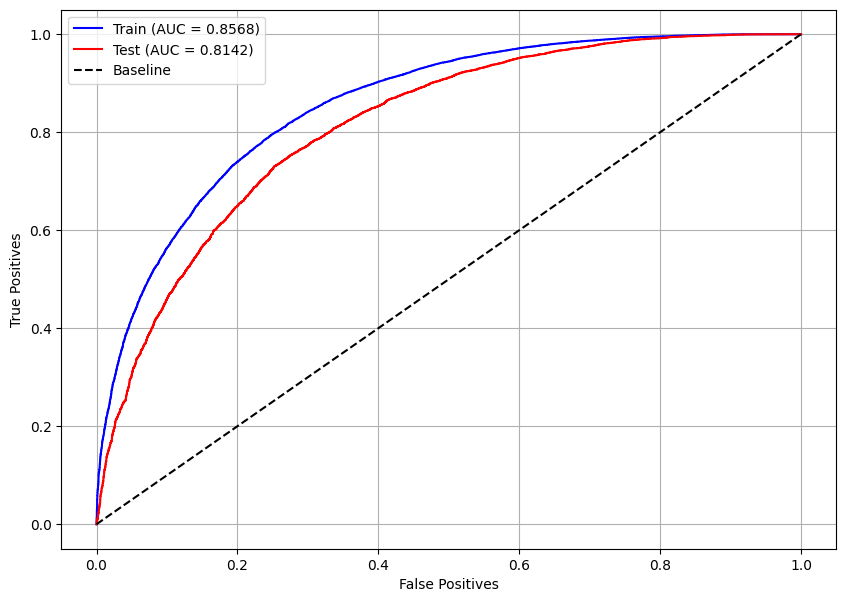

In [60]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [62]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 126,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.2,
 'min_child_weight': 2,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(0.32, 0.34, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

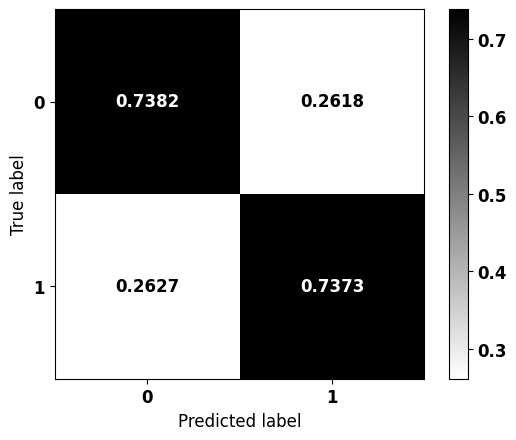


              precision    recall  f1-score   support

           0     0.5367    0.7382    0.6215      4997
           1     0.8724    0.7373    0.7992     12126

    accuracy                         0.7376     17123
   macro avg     0.7045    0.7378    0.7104     17123
weighted avg     0.7744    0.7376    0.7473     17123



In [64]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.3306

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

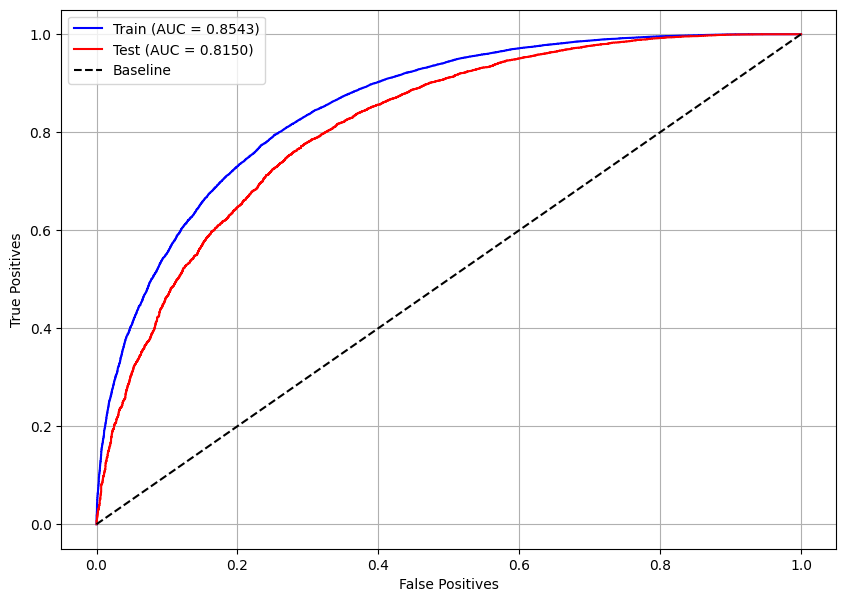

In [65]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

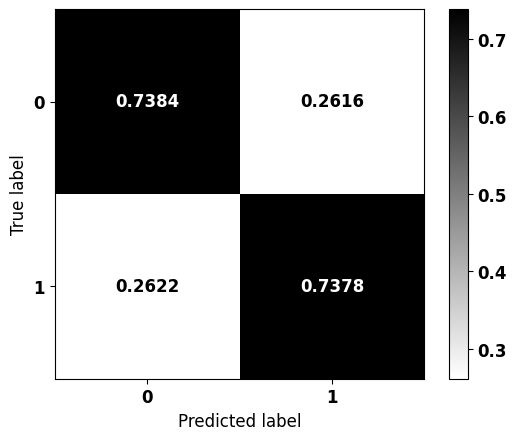


              precision    recall  f1-score   support

           0     0.5371    0.7384    0.6219      4997
           1     0.8725    0.7378    0.7995     12126

    accuracy                         0.7380     17123
   macro avg     0.7048    0.7381    0.7107     17123
weighted avg     0.7746    0.7380    0.7477     17123



In [66]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 104, 'max_depth': 6, 'learning_rate': 0.2,
          'gamma': 0.1, 'min_child_weight': 2, 'colsample_bytree': 0.5}

params['random_state'] = seed
params['scale_pos_weight'] = 0.329

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

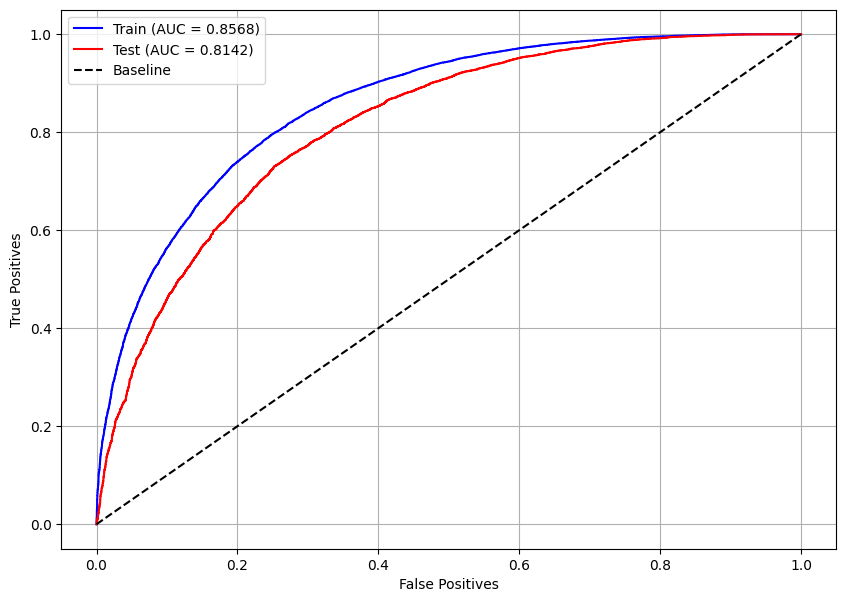

In [67]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

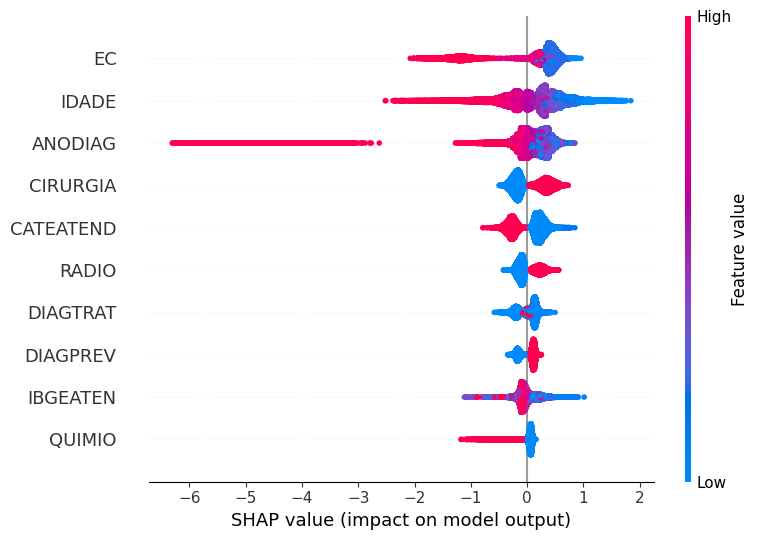

In [68]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

## **LightGBM**


### **Modelo base**

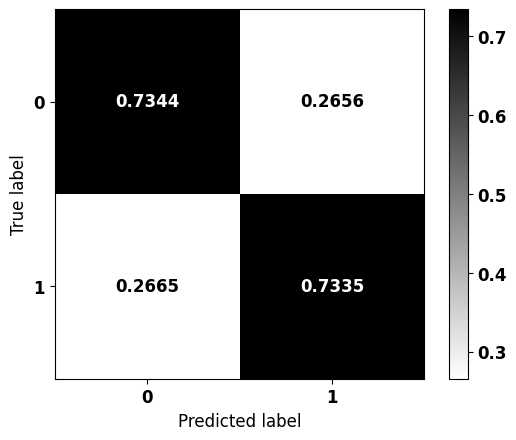


              precision    recall  f1-score   support

           0     0.5318    0.7344    0.6169      4997
           1     0.8702    0.7335    0.7960     12126

    accuracy                         0.7338     17123
   macro avg     0.7010    0.7340    0.7065     17123
weighted avg     0.7714    0.7338    0.7438     17123



In [69]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=8,
                      class_weight={0:2.976, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

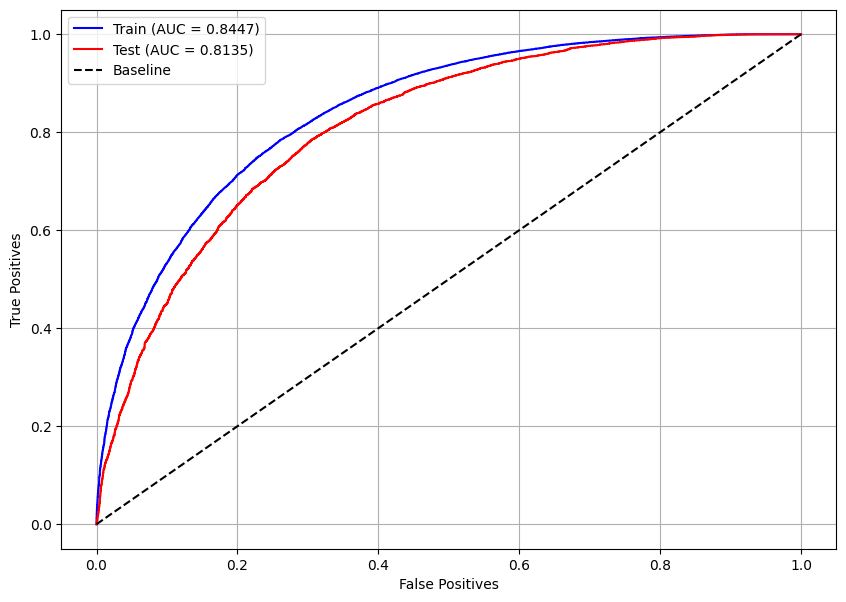

In [70]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

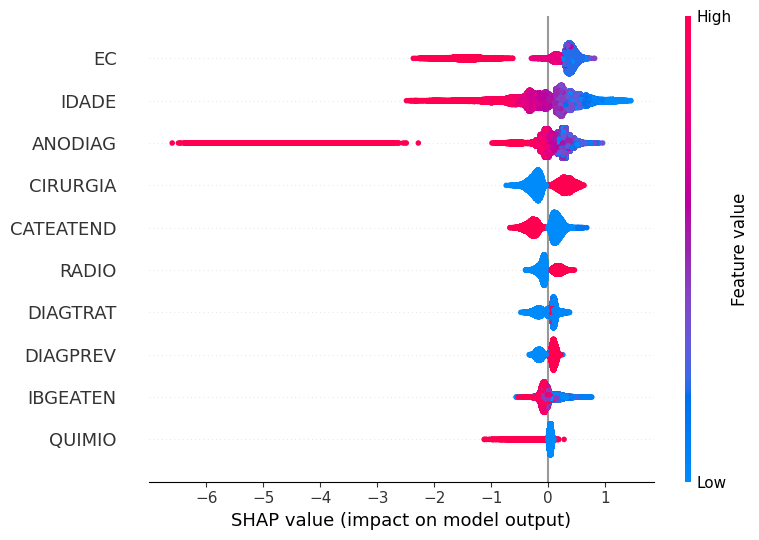

In [71]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

### **Optuna**

In [72]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelo e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [74]:
# Melhor tentativa
studyLGBM.best_trial

FrozenTrial(number=52, state=TrialState.COMPLETE, values=[0.8008253981104649], datetime_start=datetime.datetime(2023, 10, 17, 15, 22, 59, 21677), datetime_complete=datetime.datetime(2023, 10, 17, 15, 23, 15, 73732), params={'n_estimators': 97, 'max_depth': 6, 'learning_rate': 0.16, 'min_child_weight': 7, 'colsample_bytree': 0.6000000000000001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=8, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.01), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=52, value=None)

In [75]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 97,
 'max_depth': 6,
 'learning_rate': 0.16,
 'min_child_weight': 7,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(2.9, 3.1, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

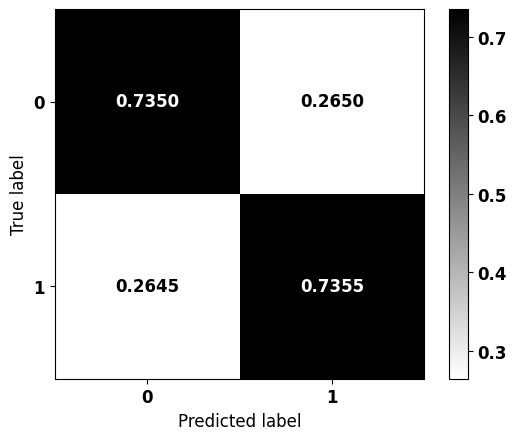


              precision    recall  f1-score   support

           0     0.5339    0.7350    0.6185      4997
           1     0.8707    0.7355    0.7974     12126

    accuracy                         0.7354     17123
   macro avg     0.7023    0.7353    0.7080     17123
weighted avg     0.7724    0.7354    0.7452     17123



In [79]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:2.993, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

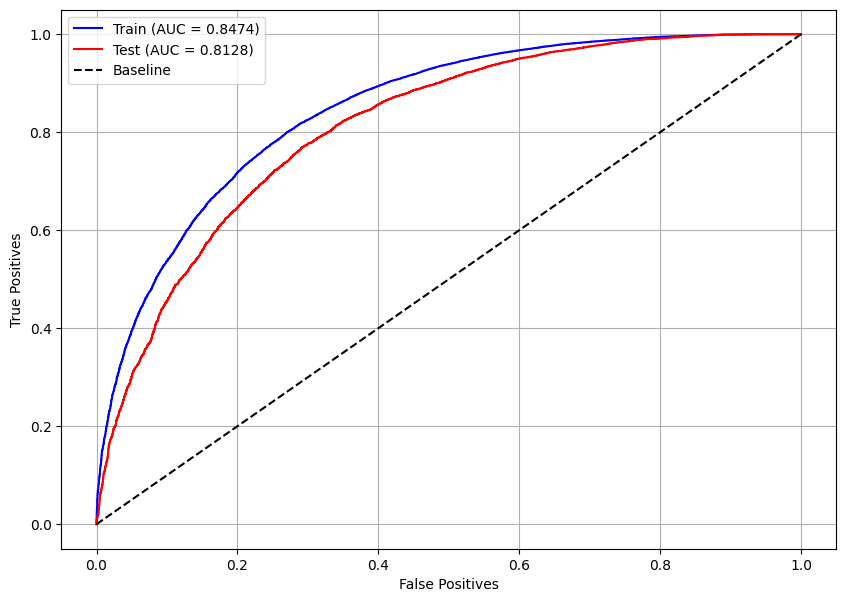

In [80]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [82]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 141,
 'max_depth': 8,
 'learning_rate': 0.12000000000000001,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(2.9, 3.1, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

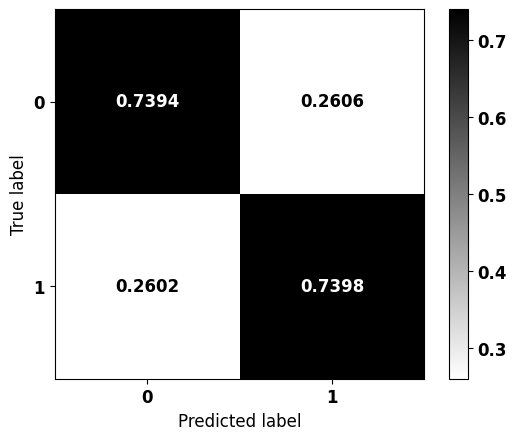


              precision    recall  f1-score   support

           0     0.5394    0.7394    0.6238      4997
           1     0.8733    0.7398    0.8010     12126

    accuracy                         0.7397     17123
   macro avg     0.7063    0.7396    0.7124     17123
weighted avg     0.7758    0.7397    0.7493     17123



In [84]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:2.976, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

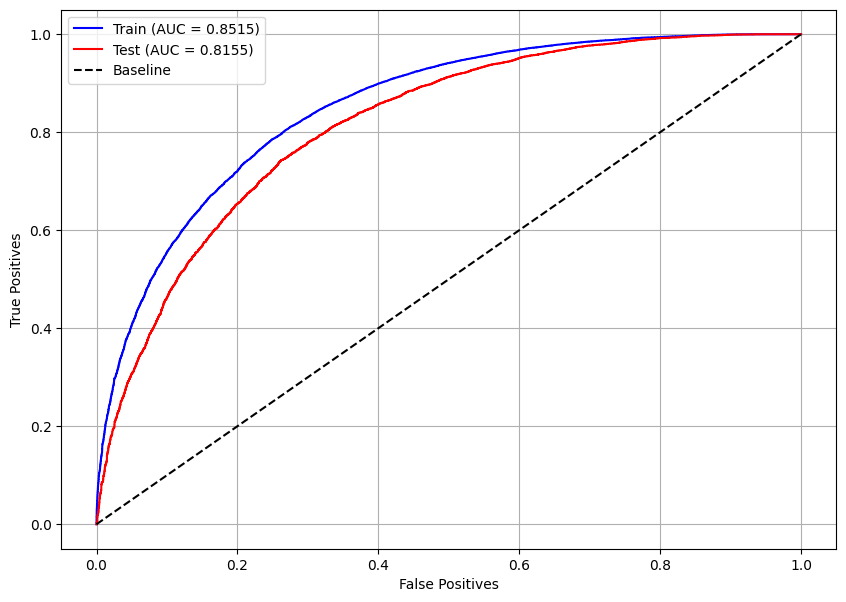

In [85]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [87]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 104,
 'max_depth': 8,
 'learning_rate': 0.11,
 'min_child_weight': 4,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(2.9, 3.1, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

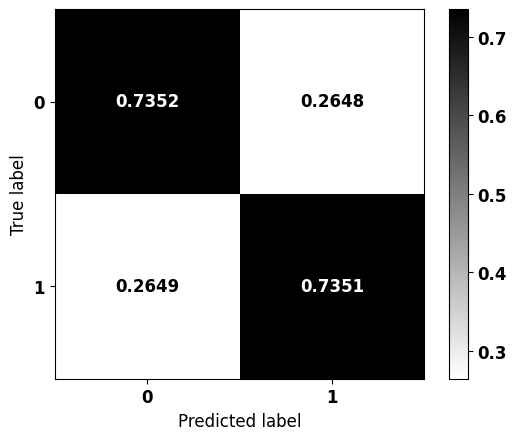


              precision    recall  f1-score   support

           0     0.5335    0.7352    0.6184      4997
           1     0.8708    0.7351    0.7972     12126

    accuracy                         0.7352     17123
   macro avg     0.7022    0.7352    0.7078     17123
weighted avg     0.7724    0.7352    0.7450     17123



In [89]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:2.97, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

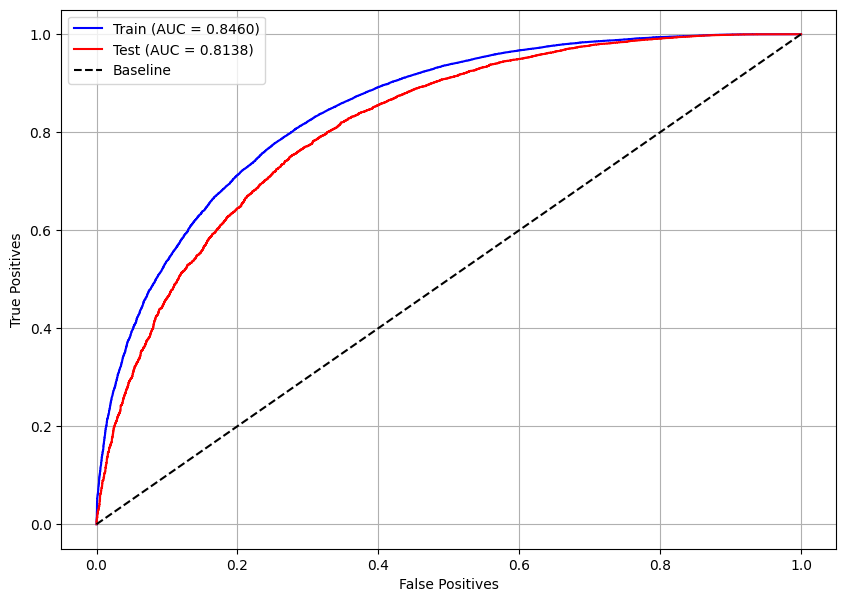

In [90]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

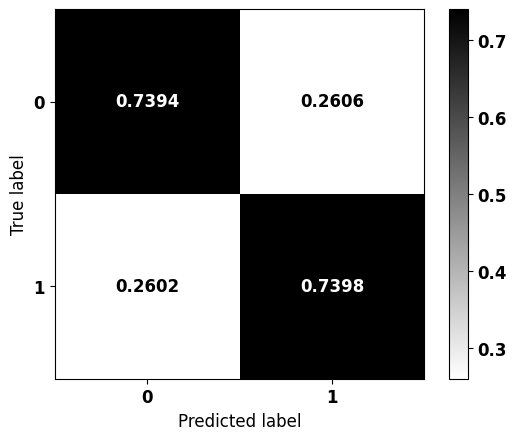


              precision    recall  f1-score   support

           0     0.5394    0.7394    0.6238      4997
           1     0.8733    0.7398    0.8010     12126

    accuracy                         0.7397     17123
   macro avg     0.7063    0.7396    0.7124     17123
weighted avg     0.7758    0.7397    0.7493     17123



In [91]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 141, 'max_depth': 8, 'learning_rate': 0.12,
          'min_child_weight': 5, 'colsample_bytree': 0.4}

params['random_state'] = seed
params['class_weight'] = {0:2.976, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

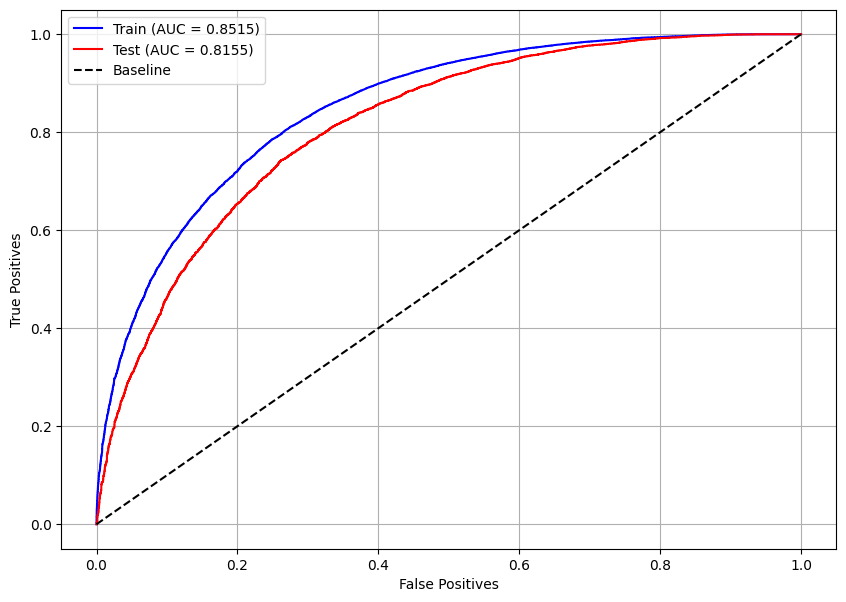

In [92]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

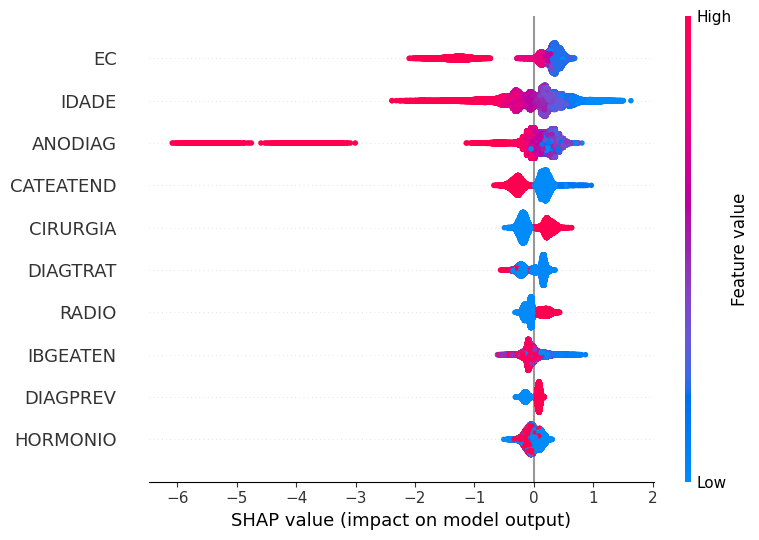

In [93]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Voting Classifier**


In [94]:
# Melhores hiperparâmetros do modelo Random Forest
rf_score = rf.score(X_test, y_test)
optuna_score = rf_optuna.score(X_test, y_test)
print(f'Accuracy: RF = {rf_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= rf_score:
    params_rf = rf_optuna.get_params()
    print('Otimizado venceu')
else:
    params_rf = rf.get_params()
    print('Modelo inicial venceu')

Accuracy: RF = 0.7242, Optuna = 0.7267

Otimizado venceu


In [95]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7326, Optuna = 0.7380

Otimizado venceu


In [96]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7338, Optuna = 0.7397

Otimizado venceu


In [99]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# Random Forest
best_rf = RandomForestClassifier()
best_rf.set_params(**params_rf)

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 2.976, 1: 1}, colsample_bytree=0.4,
               learning_rate=0.12, max_depth=8, min_child_weight=5,
               n_estimators=141, random_state=7, verbose=-1)

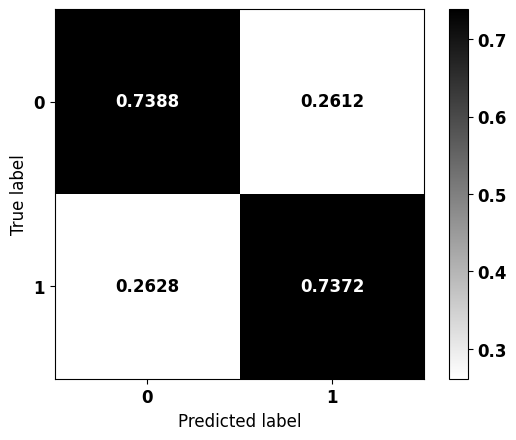


              precision    recall  f1-score   support

           0     0.5367    0.7388    0.6218      4997
           1     0.8726    0.7372    0.7992     12126

    accuracy                         0.7377     17123
   macro avg     0.7047    0.7380    0.7105     17123
weighted avg     0.7746    0.7377    0.7474     17123



In [104]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[#('RandomForest', best_rf),
                                   ('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

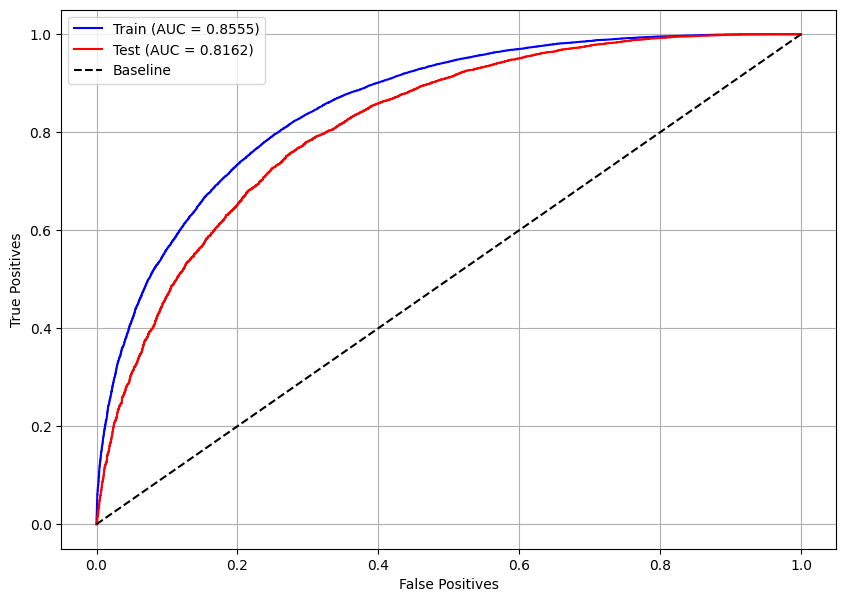

In [105]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

## **Testes com outros tipos de câncer**

In [97]:
# Melhor modelo
models = [rf, rf_optuna, xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 2.976, 1: 1}, colsample_bytree=0.4,
               learning_rate=0.12, max_depth=8, min_child_weight=5,
               n_estimators=141, random_state=7, verbose=-1)


In [98]:
# Colunas que não serão utilizadas na predição cruzada
list_drop = list_drop + [lb]
list_drop

['TRATHOSP',
 'TOPO',
 'TOPOGRUP',
 'obito_geral',
 'sobrevida_ano1',
 'sobrevida_ano3',
 'sobrevida_ano5']

### **Colorretal**

In [106]:
df_colorretal = pd.read_csv('/content/colorretal.csv')
print(df_colorretal.shape)
df_colorretal.head(3)

(60887, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3548708,9,1,C180,C18,III,E,0,...,1,3550308,1,3.0,0,0,1,1,0,0
1,26,2,3550308,9,1,C180,C18,III,A,0,...,6,3550308,2,2.0,1,0,0,1,1,1
2,22,2,3503208,9,2,C180,C18,IV,C,0,...,13,3503208,1,4.0,1,0,1,0,0,0


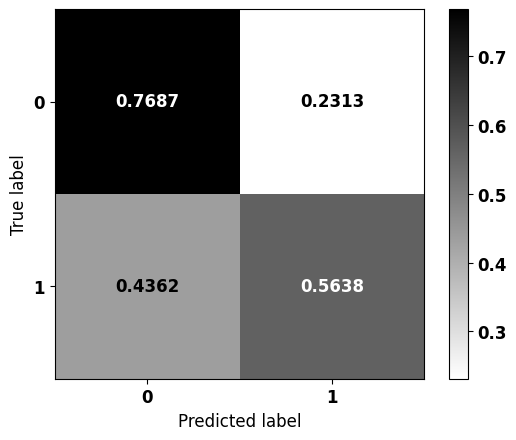


              precision    recall  f1-score   support

           0     0.7324    0.7687    0.7501     29592
           1     0.6108    0.5638    0.5864     19051

    accuracy                         0.6885     48643
   macro avg     0.6716    0.6663    0.6683     48643
weighted avg     0.6848    0.6885    0.6860     48643



In [107]:
pred_cruzada(df_colorretal, best, list_drop, lb, enc, norm)

### **Pulmão**

In [108]:
df_pulmao = pd.read_csv('/content/pulmao.csv')
print(df_pulmao.shape)
df_pulmao.head(3)

(38646, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3520103,9,1,C340,C34,IIIB,J,1,...,13,3505500,2,2.0,0,0,1,0,0,0
1,28,2,3554508,9,1,C340,C34,IIIB,C,0,...,8,3525300,2,3.0,0,1,1,1,0,0
2,27,2,3507001,2,2,C340,C34,IV,F,0,...,8,3525300,2,4.0,0,0,1,0,0,0


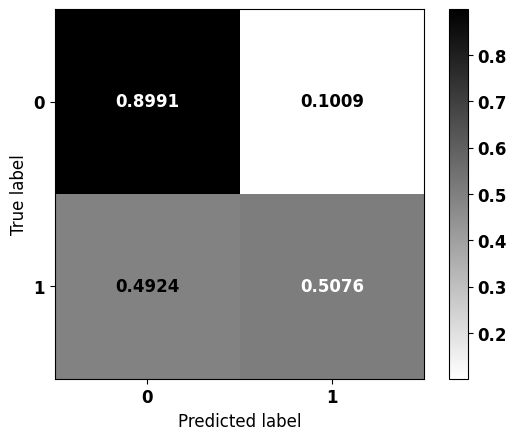


              precision    recall  f1-score   support

           0     0.9627    0.8991    0.9298     33335
           1     0.2624    0.5076    0.3460      2358

    accuracy                         0.8732     35693
   macro avg     0.6126    0.7034    0.6379     35693
weighted avg     0.9164    0.8732    0.8912     35693



In [109]:
pred_cruzada(df_pulmao, best, list_drop, lb, enc, norm)

### **Mama**

In [110]:
df_mama = pd.read_csv('/content/mama.csv')
print(df_mama.shape)
df_mama.head(3)

(117338, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,102,2,3550308,9,1,C509,C50,IIIB,D,0,...,6,3550308,2,3.0,1,1,1,1,0,0
1,28,2,3547809,9,2,C500,C50,I,G,0,...,1,3547809,1,4.0,1,0,1,1,1,1
2,27,2,3512001,2,2,C500,C50,I,H,0,...,13,3505500,2,4.0,0,1,0,1,1,1


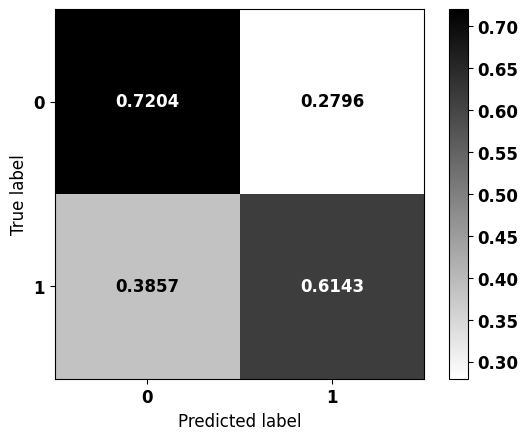


              precision    recall  f1-score   support

           0     0.4953    0.7204    0.5870     29453
           1     0.8071    0.6143    0.6976     56061

    accuracy                         0.6509     85514
   macro avg     0.6512    0.6674    0.6423     85514
weighted avg     0.6997    0.6509    0.6595     85514



In [111]:
pred_cruzada(df_mama, best, list_drop, lb, enc, norm)

### **Colo de Útero**

In [112]:
df_colo_utero = pd.read_csv('/content/colo_utero.csv')
print(df_colo_utero.shape)
df_colo_utero.head(3)

(23306, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,27,2,3548906,9,2,C530,C53,IIIB,B,0,...,13,3503208,1,4.0,0,0,1,1,0,0
1,29,2,3518701,9,1,C530,C53,IB2,E,0,...,7,3518701,1,3.0,1,0,1,1,0,0
2,29,2,3522109,2,2,C530,C53,IB1,A,0,...,7,3550308,2,3.0,0,1,0,1,1,1


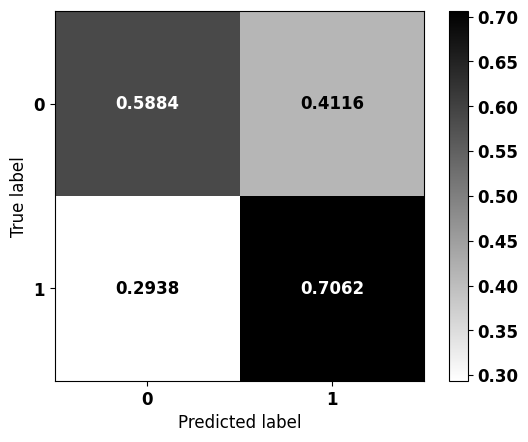


              precision    recall  f1-score   support

           0     0.7168    0.5884    0.6463     10641
           1     0.5759    0.7062    0.6344      8421

    accuracy                         0.6404     19062
   macro avg     0.6463    0.6473    0.6403     19062
weighted avg     0.6545    0.6404    0.6410     19062



In [113]:
pred_cruzada(df_colo_utero, best, list_drop, lb, enc, norm)

### **Pele**

In [114]:
df_pele = pd.read_csv('/content/pele.csv')
print(df_pele.shape)
df_pele.head(3)

(183164, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,101,2,3543402,9,1,C443,C44,I,I,0,...,13,3543402,2,2.0,1,0,1,1,0,0
1,100,1,3522802,2,1,C443,C44,II,A,0,...,9,3525300,2,1.0,0,0,1,1,0,0
2,105,2,3546603,9,1,C447,C44,I,A,0,...,12,3505500,2,1.0,0,0,1,0,0,0


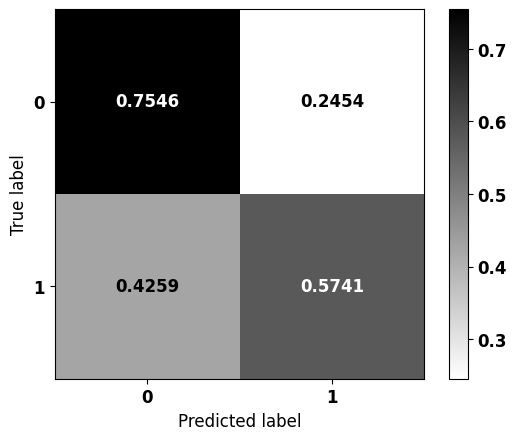


              precision    recall  f1-score   support

           0     0.5384    0.7546    0.6284     33209
           1     0.7804    0.5741    0.6616     50447

    accuracy                         0.6458     83656
   macro avg     0.6594    0.6643    0.6450     83656
weighted avg     0.6843    0.6458    0.6484     83656



In [115]:
pred_cruzada(df_pele, best, list_drop, lb, enc, norm)